In [15]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, cross_validate,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import joblib
from sklearn.inspection import permutation_importance

In [ ]:
import os
os.chdir(r'C:\Users\ADMIN\Desktop\EMLforSAI')  #Replace with the file path of EMLforSAI in your system.

In [ ]:
# 1. 读取数据
df=pd.read_csv(r'./Dataset/ML_data.csv')

In [9]:
# 2. 数据预处理
df = df.dropna(subset=['y'])
feature_columns = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'B5', 
                   'C1', 'C2', 'C3', 'C4']

def categorize_y(value):
    if pd.isna(value):
        return np.nan
    elif value <= 3:
        return 2
    elif value == 4:
        return 1
    elif value == 5:
        return 0
    else:
        return np.nan

df['y_category'] = df['y'].apply(categorize_y)
df = df.dropna(subset=['y_category'])

X = df[feature_columns]
y = df['y_category']

# 3. 设置五折交叉验证
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("=== Optuna贝叶斯优化调参 (KNN) ===")
print(f"样本数: {len(X)}, 特征数: {len(feature_columns)}")
print(f"类别分布: {dict(y.value_counts().sort_index())}")
print(f"类别比例: {y.value_counts(normalize=True).sort_index().values}")

# 4. 定义Optuna目标函数 (针对KNN)
def objective(trial):
    """
    Optuna目标函数，返回交叉验证的准确率
    """
    # 定义KNN参数搜索空间
    n_neighbors = trial.suggest_int('n_neighbors', 3, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    
    # 距离度量参数
    p = trial.suggest_int('p', 1, 3)  # 1:曼哈顿距离，2:欧氏距离，3:闵可夫斯基距离
    
    # 算法参数
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    
    # 叶子大小（当算法使用ball_tree或kd_tree时）
    leaf_size = trial.suggest_int('leaf_size', 10, 50)
    
    # 创建KNN模型
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p,
        algorithm=algorithm,
        leaf_size=leaf_size,
        n_jobs=-1  # 使用所有CPU核心
    )
    
    # 创建Pipeline：标准化 + KNN
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', model)
    ])
    
    # 使用交叉验证计算分数
    scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy', n_jobs=1)
    
    # 返回平均准确率
    return np.mean(scores)

# 5. 创建Optuna研究并运行优化
print("\n开始Optuna贝叶斯优化...")
study = optuna.create_study(
    direction='maximize',  # 最大化准确率
    sampler=TPESampler(seed=42),  # 使用TPE采样器
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3, interval_steps=1)
)

# 运行优化
n_trials = 100  # 试验次数
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# 6. 输出优化结果
print("\n" + "="*60)
print("Optuna优化结果")
print("="*60)
print(f"最佳试验编号: {study.best_trial.number}")
print(f"最佳准确率: {study.best_value:.4f}")
print(f"最佳参数:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-12-21 00:06:17,289] A new study created in memory with name: no-name-08693ab9-0901-43af-84f9-d6a7c9459260


=== Optuna贝叶斯优化调参 (KNN) ===
样本数: 687, 特征数: 13
类别分布: {0: 148, 1: 289, 2: 250}
类别比例: [0.2154294  0.42066958 0.36390102]

开始Optuna贝叶斯优化...


Best trial: 0. Best value: 0.807934:   1%|          | 1/100 [00:00<00:55,  1.78it/s]

[I 2025-12-21 00:06:17,851] Trial 0 finished with value: 0.8079339892097746 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2, 'algorithm': 'brute', 'leaf_size': 34}. Best is trial 0 with value: 0.8079339892097746.


Best trial: 0. Best value: 0.807934:   2%|▏         | 2/100 [00:01<00:56,  1.75it/s]

[I 2025-12-21 00:06:18,431] Trial 1 finished with value: 0.7918967523537501 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'p': 3, 'algorithm': 'brute', 'leaf_size': 31}. Best is trial 0 with value: 0.8079339892097746.


Best trial: 2. Best value: 0.813784:   3%|▎         | 3/100 [00:01<00:55,  1.75it/s]

[I 2025-12-21 00:06:18,997] Trial 2 finished with value: 0.8137839839204485 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1, 'algorithm': 'brute', 'leaf_size': 18}. Best is trial 2 with value: 0.8137839839204485.


Best trial: 2. Best value: 0.813784:   4%|▍         | 4/100 [00:02<00:55,  1.74it/s]

[I 2025-12-21 00:06:19,577] Trial 3 finished with value: 0.8093938432243732 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 2, 'algorithm': 'brute', 'leaf_size': 43}. Best is trial 2 with value: 0.8137839839204485.


Best trial: 2. Best value: 0.813784:   5%|▌         | 5/100 [00:02<00:54,  1.75it/s]

[I 2025-12-21 00:06:20,144] Trial 4 finished with value: 0.8050248598328574 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 2, 'algorithm': 'brute', 'leaf_size': 20}. Best is trial 2 with value: 0.8137839839204485.


Best trial: 6. Best value: 0.815233:   6%|▌         | 6/100 [00:06<02:37,  1.67s/it]

[I 2025-12-21 00:06:23,953] Trial 5 finished with value: 0.8108536972389718 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'p': 2, 'algorithm': 'ball_tree', 'leaf_size': 46}. Best is trial 2 with value: 0.8137839839204485.
[I 2025-12-21 00:06:24,051] Trial 6 finished with value: 0.8152332592827672 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 43}. Best is trial 6 with value: 0.8152332592827672.


Best trial: 6. Best value: 0.815233:   8%|▊         | 8/100 [00:06<01:22,  1.12it/s]

[I 2025-12-21 00:06:24,143] Trial 7 finished with value: 0.8123135512535702 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 18}. Best is trial 6 with value: 0.8152332592827672.
[I 2025-12-21 00:06:24,240] Trial 8 finished with value: 0.7642335766423358 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 3, 'algorithm': 'auto', 'leaf_size': 45}. Best is trial 6 with value: 0.8152332592827672.


Best trial: 10. Best value: 0.821052:  11%|█         | 11/100 [00:07<00:48,  1.85it/s]

[I 2025-12-21 00:06:24,827] Trial 9 finished with value: 0.8181423886596846 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'p': 1, 'algorithm': 'brute', 'leaf_size': 29}. Best is trial 9 with value: 0.8181423886596846.
[I 2025-12-21 00:06:24,935] Trial 10 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 11}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  13%|█▎        | 13/100 [00:07<00:30,  2.87it/s]

[I 2025-12-21 00:06:25,041] Trial 11 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 10}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:25,149] Trial 12 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 10}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  15%|█▌        | 15/100 [00:08<00:19,  4.28it/s]

[I 2025-12-21 00:06:25,254] Trial 13 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 10}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:25,361] Trial 14 finished with value: 0.8181318100074051 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 24}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  17%|█▋        | 17/100 [00:08<00:14,  5.86it/s]

[I 2025-12-21 00:06:25,468] Trial 15 finished with value: 0.8064847138474558 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'p': 2, 'algorithm': 'auto', 'leaf_size': 14}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:25,573] Trial 16 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 23}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  19%|█▉        | 19/100 [00:08<00:11,  7.27it/s]

[I 2025-12-21 00:06:25,680] Trial 17 finished with value: 0.7904368983391515 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'p': 3, 'algorithm': 'auto', 'leaf_size': 15}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:25,783] Trial 18 finished with value: 0.8050037025282979 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'p': 2, 'algorithm': 'auto', 'leaf_size': 38}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  21%|██        | 21/100 [00:08<00:09,  8.19it/s]

[I 2025-12-21 00:06:25,888] Trial 19 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 26}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:25,995] Trial 20 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 14}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  23%|██▎       | 23/100 [00:08<00:09,  8.11it/s]

[I 2025-12-21 00:06:26,101] Trial 21 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 10}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:26,238] Trial 22 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 10}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  25%|██▌       | 25/100 [00:09<00:08,  8.78it/s]

[I 2025-12-21 00:06:26,345] Trial 23 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 14}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:26,449] Trial 24 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 19}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  27%|██▋       | 27/100 [00:09<00:07,  9.23it/s]

[I 2025-12-21 00:06:26,554] Trial 25 finished with value: 0.8064847138474558 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'p': 2, 'algorithm': 'auto', 'leaf_size': 12}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:26,655] Trial 26 finished with value: 0.8181318100074051 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'p': 1, 'algorithm': 'auto', 'leaf_size': 50}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  29%|██▉       | 29/100 [00:09<00:07,  9.38it/s]

[I 2025-12-21 00:06:26,761] Trial 27 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 16}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:26,866] Trial 28 finished with value: 0.8079445678620545 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'p': 2, 'algorithm': 'auto', 'leaf_size': 21}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  31%|███       | 31/100 [00:09<00:07,  9.47it/s]

[I 2025-12-21 00:06:26,970] Trial 29 finished with value: 0.8050248598328572 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 35}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:27,075] Trial 30 finished with value: 0.8151803660213689 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 12}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  33%|███▎      | 33/100 [00:09<00:07,  9.43it/s]

[I 2025-12-21 00:06:27,182] Trial 31 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 17}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:27,288] Trial 32 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 22}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  35%|███▌      | 35/100 [00:10<00:06,  9.56it/s]

[I 2025-12-21 00:06:27,395] Trial 33 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 27}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:27,496] Trial 34 finished with value: 0.8181318100074051 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 12}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  37%|███▋      | 37/100 [00:10<00:12,  5.01it/s]

[I 2025-12-21 00:06:28,056] Trial 35 finished with value: 0.8123135512535702 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1, 'algorithm': 'brute', 'leaf_size': 22}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:28,159] Trial 36 finished with value: 0.7918967523537501 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'p': 3, 'algorithm': 'ball_tree', 'leaf_size': 31}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  38%|███▊      | 38/100 [00:10<00:10,  5.81it/s]

[I 2025-12-21 00:06:28,266] Trial 37 finished with value: 0.8035755844705385 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'p': 2, 'algorithm': 'auto', 'leaf_size': 12}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  40%|████      | 40/100 [00:11<00:14,  4.13it/s]

[I 2025-12-21 00:06:28,865] Trial 38 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'p': 1, 'algorithm': 'brute', 'leaf_size': 16}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:28,972] Trial 39 finished with value: 0.8152332592827672 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 33}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  42%|████▏     | 42/100 [00:11<00:10,  5.78it/s]

[I 2025-12-21 00:06:29,079] Trial 40 finished with value: 0.8079339892097746 and parameters: {'n_neighbors': 35, 'weights': 'uniform', 'p': 2, 'algorithm': 'auto', 'leaf_size': 19}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:29,185] Trial 41 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 25}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  44%|████▍     | 44/100 [00:12<00:07,  7.19it/s]

[I 2025-12-21 00:06:29,291] Trial 42 finished with value: 0.8181318100074051 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 27}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:29,398] Trial 43 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 38}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  46%|████▌     | 46/100 [00:12<00:06,  8.15it/s]

[I 2025-12-21 00:06:29,507] Trial 44 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 25}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:29,613] Trial 45 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 29}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  48%|████▊     | 48/100 [00:12<00:11,  4.72it/s]

[I 2025-12-21 00:06:30,179] Trial 46 finished with value: 0.8152121019782079 and parameters: {'n_neighbors': 43, 'weights': 'distance', 'p': 1, 'algorithm': 'brute', 'leaf_size': 23}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:30,288] Trial 47 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 13}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  50%|█████     | 50/100 [00:13<00:07,  6.31it/s]

[I 2025-12-21 00:06:30,396] Trial 48 finished with value: 0.8137734052681689 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 10}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:30,502] Trial 49 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 18}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  52%|█████▏    | 52/100 [00:13<00:06,  7.58it/s]

[I 2025-12-21 00:06:30,608] Trial 50 finished with value: 0.8064847138474558 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'p': 2, 'algorithm': 'auto', 'leaf_size': 27}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:30,716] Trial 51 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 15}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  54%|█████▍    | 54/100 [00:13<00:05,  8.40it/s]

[I 2025-12-21 00:06:30,823] Trial 52 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 14}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:30,930] Trial 53 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 20}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  56%|█████▌    | 56/100 [00:13<00:04,  8.82it/s]

[I 2025-12-21 00:06:31,037] Trial 54 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 10}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:31,145] Trial 55 finished with value: 0.8181318100074051 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 11}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  58%|█████▊    | 58/100 [00:14<00:04,  9.03it/s]

[I 2025-12-21 00:06:31,254] Trial 56 finished with value: 0.7875171903099545 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 3, 'algorithm': 'auto', 'leaf_size': 13}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:31,361] Trial 57 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 17}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  59%|█████▉    | 59/100 [00:14<00:04,  9.23it/s]

[I 2025-12-21 00:06:31,465] Trial 58 finished with value: 0.8166719559928065 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'p': 1, 'algorithm': 'auto', 'leaf_size': 15}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  61%|██████    | 61/100 [00:14<00:08,  4.80it/s]

[I 2025-12-21 00:06:32,047] Trial 59 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'p': 1, 'algorithm': 'brute', 'leaf_size': 13}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:32,158] Trial 60 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 11}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  63%|██████▎   | 63/100 [00:15<00:05,  6.34it/s]

[I 2025-12-21 00:06:32,265] Trial 61 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 10}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:32,375] Trial 62 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 11}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  65%|██████▌   | 65/100 [00:15<00:04,  7.32it/s]

[I 2025-12-21 00:06:32,483] Trial 63 finished with value: 0.8137839839204485 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 15}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:32,604] Trial 64 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 13}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  67%|██████▋   | 67/100 [00:15<00:04,  8.21it/s]

[I 2025-12-21 00:06:32,714] Trial 65 finished with value: 0.8035544271659791 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 2, 'algorithm': 'auto', 'leaf_size': 17}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:32,820] Trial 66 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 12}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  69%|██████▉   | 69/100 [00:15<00:03,  8.69it/s]

[I 2025-12-21 00:06:32,929] Trial 67 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 11}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:33,038] Trial 68 finished with value: 0.8181318100074051 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 14}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  71%|███████   | 71/100 [00:15<00:03,  9.06it/s]

[I 2025-12-21 00:06:33,140] Trial 69 finished with value: 0.8137734052681689 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 20}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:33,249] Trial 70 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 10}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  73%|███████▎  | 73/100 [00:16<00:02,  9.13it/s]

[I 2025-12-21 00:06:33,357] Trial 71 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 16}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:33,466] Trial 72 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 14}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  75%|███████▌  | 75/100 [00:16<00:02,  9.13it/s]

[I 2025-12-21 00:06:33,573] Trial 73 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 25}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:33,683] Trial 74 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 12}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  77%|███████▋  | 77/100 [00:16<00:02,  9.24it/s]

[I 2025-12-21 00:06:33,795] Trial 75 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 29}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:33,899] Trial 76 finished with value: 0.7918861737014704 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 37}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  79%|███████▉  | 79/100 [00:17<00:04,  4.69it/s]

[I 2025-12-21 00:06:34,505] Trial 77 finished with value: 0.8181318100074051 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'p': 1, 'algorithm': 'brute', 'leaf_size': 18}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:34,616] Trial 78 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 31}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  81%|████████  | 81/100 [00:17<00:03,  6.33it/s]

[I 2025-12-21 00:06:34,719] Trial 79 finished with value: 0.7933142917592299 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 14}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:34,825] Trial 80 finished with value: 0.8050142811805776 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'p': 2, 'algorithm': 'auto', 'leaf_size': 23}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  83%|████████▎ | 83/100 [00:17<00:02,  7.58it/s]

[I 2025-12-21 00:06:34,931] Trial 81 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 21}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:35,038] Trial 82 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 26}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  85%|████████▌ | 85/100 [00:17<00:01,  8.37it/s]

[I 2025-12-21 00:06:35,144] Trial 83 finished with value: 0.8181318100074051 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 19}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:35,253] Trial 84 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 16}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  87%|████████▋ | 87/100 [00:18<00:01,  8.78it/s]

[I 2025-12-21 00:06:35,358] Trial 85 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 23}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:35,469] Trial 86 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 34, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 11}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  89%|████████▉ | 89/100 [00:18<00:01,  9.03it/s]

[I 2025-12-21 00:06:35,575] Trial 87 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 12}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:35,683] Trial 88 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 13}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  91%|█████████ | 91/100 [00:19<00:01,  4.68it/s]

[I 2025-12-21 00:06:36,290] Trial 89 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'p': 1, 'algorithm': 'brute', 'leaf_size': 50}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:36,398] Trial 90 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 10}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  93%|█████████▎| 93/100 [00:19<00:01,  6.25it/s]

[I 2025-12-21 00:06:36,506] Trial 91 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 16}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:36,615] Trial 92 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 21}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  95%|█████████▌| 95/100 [00:19<00:00,  7.45it/s]

[I 2025-12-21 00:06:36,723] Trial 93 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 15}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:36,833] Trial 94 finished with value: 0.8210515180366021 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 19}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 10. Best value: 0.821052:  97%|█████████▋| 97/100 [00:19<00:00,  8.16it/s]

[I 2025-12-21 00:06:36,948] Trial 95 finished with value: 0.8181318100074051 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 11}. Best is trial 10 with value: 0.8210515180366021.
[I 2025-12-21 00:06:37,057] Trial 96 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'p': 1, 'algorithm': 'auto', 'leaf_size': 17}. Best is trial 10 with value: 0.8210515180366021.


Best trial: 97. Best value: 0.822501:  99%|█████████▉| 99/100 [00:19<00:00,  8.69it/s]

[I 2025-12-21 00:06:37,165] Trial 97 finished with value: 0.8225007933989211 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 13}. Best is trial 97 with value: 0.8225007933989211.
[I 2025-12-21 00:06:37,273] Trial 98 finished with value: 0.8225007933989211 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 13}. Best is trial 97 with value: 0.8225007933989211.


Best trial: 97. Best value: 0.822501: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]

[I 2025-12-21 00:06:37,379] Trial 99 finished with value: 0.8195916640220036 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 13}. Best is trial 97 with value: 0.8225007933989211.

Optuna优化结果
最佳试验编号: 97
最佳准确率: 0.8225
最佳参数:
  n_neighbors: 36
  weights: uniform
  p: 1
  algorithm: ball_tree
  leaf_size: 13


In [10]:
# 8. 使用最佳参数训练最终模型
print("\n" + "="*60)
print("使用最佳参数训练最终模型")
print("="*60)

# 从最佳参数中提取KNN参数
best_params = study.best_params

# 创建最终Pipeline
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(**best_params, n_jobs=-1))
])

# 在整个数据集上训练
final_model.fit(X, y)

# 9. 交叉验证评估最佳模型
print("\n评估最佳模型的交叉验证性能...")
cv_scores = cross_val_score(final_model, X, y, cv=kfold, scoring='accuracy')
print(f"五折交叉验证准确率: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"各折准确率: {[f'{score:.4f}' for score in cv_scores]}")

# 10. 更详细的模型评估
print("\n" + "="*60)
print("详细模型评估")
print("="*60)

# 使用交叉验证预测
y_pred_cv = cross_val_predict(final_model, X, y, cv=kfold)

# 计算各种评估指标
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(y, y_pred_cv)
precision_macro = precision_score(y, y_pred_cv, average='macro')
recall_macro = recall_score(y, y_pred_cv, average='macro')
f1_macro = f1_score(y, y_pred_cv, average='macro')
precision_weighted = precision_score(y, y_pred_cv, average='weighted')
recall_weighted = recall_score(y, y_pred_cv, average='weighted')
f1_weighted = f1_score(y, y_pred_cv, average='weighted')

print("整体性能指标:")
print(f"  准确率 (Accuracy): {accuracy:.4f}")
print(f"\n宏平均 (Macro-average):")
print(f"  精确率 (Precision): {precision_macro:.4f}")
print(f"  召回率 (Recall): {recall_macro:.4f}")
print(f"  F1分数: {f1_macro:.4f}")
print(f"\n加权平均 (Weighted-average):")
print(f"  精确率 (Precision): {precision_weighted:.4f}")
print(f"  召回率 (Recall): {recall_weighted:.4f}")
print(f"  F1分数: {f1_weighted:.4f}")

# 分类报告
print("\n详细分类报告:")
print(classification_report(y, y_pred_cv, 
                           target_names=['y≤3 (类别0)', 'y=4 (类别1)', 'y=5 (类别2)']))


使用最佳参数训练最终模型

评估最佳模型的交叉验证性能...
五折交叉验证准确率: 0.8225 (±0.0420)
各折准确率: ['0.7971', '0.7899', '0.8102', '0.9051', '0.8102']

详细模型评估
整体性能指标:
  准确率 (Accuracy): 0.8224

宏平均 (Macro-average):
  精确率 (Precision): 0.8324
  召回率 (Recall): 0.8206
  F1分数: 0.8249

加权平均 (Weighted-average):
  精确率 (Precision): 0.8263
  召回率 (Recall): 0.8224
  F1分数: 0.8225

详细分类报告:
              precision    recall  f1-score   support

   y≤3 (类别0)       0.85      0.82      0.84       148
   y=4 (类别1)       0.78      0.86      0.82       289
   y=5 (类别2)       0.87      0.78      0.82       250

    accuracy                           0.82       687
   macro avg       0.83      0.82      0.82       687
weighted avg       0.83      0.82      0.82       687



In [16]:
# 使用交叉验证获取预测结果
print("进行五折交叉验证预测...")
y_pred_cv = cross_val_predict(final_model, X, y, cv=kfold)
y_pred_proba_cv = cross_val_predict(final_model, X, y, cv=kfold, method='predict_proba')

# 计算交叉验证的准确率
cv_accuracy = accuracy_score(y, y_pred_cv)
print(f"五折交叉验证准确率: {cv_accuracy:.4f}")

进行五折交叉验证预测...
五折交叉验证准确率: 0.8224


In [17]:
# 保存模型
model_filename = 'KNN_optuna_optimized.pkl'
joblib.dump(final_model, model_filename)
print(f"The final model has been saved as: {model_filename}")

The final model has been saved as: KNN_optuna_optimized.pkl


In [18]:
# 交叉验证评估最佳模型
print("\nEvaluate the cross-validation performance of the best model...")
cv_scores = cross_val_score(final_model, X, y, cv=kfold, scoring='accuracy')
cv_results = cross_validate(final_model, X, y, cv=kfold, 
                           scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
print(f"Accuracy of 5-fold cross-validation: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"Accuracy for each fold: {[f'{score:.4f}' for score in cv_scores]}")


Evaluate the cross-validation performance of the best model...
Accuracy of 5-fold cross-validation: 0.8225 (±0.0420)
Accuracy for each fold: ['0.7971', '0.7899', '0.8102', '0.9051', '0.8102']


In [19]:
# 使用交叉验证获取预测结果
print("Results of five-fold cross-validation")
res=pd.DataFrame(cv_results.values()).iloc[2:].T
res.columns=['Accuracy', 'Precision', 'Recall', 'F1']
res

Results of five-fold cross-validation


,Accuracy,Precision,Recall,F1
0,0.797101,0.813037,0.782905,0.794994
1,0.789855,0.813031,0.799560,0.805730
2,0.810219,0.823743,0.820124,0.814278
3,0.905109,0.909382,0.902527,0.904981
4,0.810219,0.817975,0.802124,0.806455



Plotting a confusion matrix...
[[0.85314685 0.071875   0.01339286]
 [0.09090909 0.778125   0.12053571]
 [0.05594406 0.15       0.86607143]]


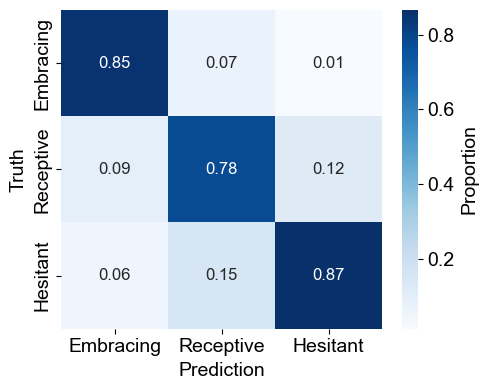

In [20]:
# 混淆矩阵
print("\nPlotting a confusion matrix...")
cm = confusion_matrix(y, y_pred_cv)

cm1 = cm / sum(cm)
print(cm1)

# 可视化混淆矩阵
plt.figure(figsize=(5, 4))
plt.rc('font', family='Arial', weight='normal')

# 创建热图并获取colorbar对象
heatmap = sns.heatmap(
    cm1, 
    annot=True, 
    fmt='.2f', 
    cmap='Blues',
    annot_kws={'size': 12},  # 设置图块标记字体大小为12
    cbar_kws={'label': 'accuracy'},  # 设置colorbar标签为accuracy
    xticklabels=['Embracing', 'Receptive', 'Hesitant'],
    yticklabels=['Embracing', 'Receptive', 'Hesitant']
)

# 设置colorbar字体为12
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Proportion', fontsize=14)  # 设置colorbar标签字体大小

# 设置坐标轴标签和刻度
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Prediction', fontsize=14)  # 添加x轴标签
plt.ylabel('Truth', fontsize=14)

plt.tight_layout()
# plt.savefig( r'CM_KNN.png', dpi=300,transparent=True,bbox_inches = 'tight')
plt.show()